In [1]:
!pip install gdown
!pip install tqdm

import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from tqdm import tqdm
import copy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# @title Download MoNuSeg Training Data and Convert Masks
import gdown
import os
from PIL import Image
import numpy as np
import xml.etree.ElementTree as ET
from skimage.draw import polygon

def parse_xml_to_mask(xml_path, image_size):

  width, height = image_size
  mask = np.zeros((height, width), dtype=np.uint8)

  tree = ET.parse(xml_path)
  root = tree.getroot()

  for region in root.findall('.//Region'):
    for vertices in region.findall('.//Vertices'):
      row_cords = []
      col_cords = []
      for vertex in vertices.findall('.//Vertex'):
        x = float(vertex.get('X'))
        y = float(vertex.get('Y'))

        row_cords.append(y)
        col_cords.append(x)

      rr, cc = polygon(row_cords, col_cords, (height, width))
      mask[rr, cc] = 1

  return mask

if not os.path.exists('MoNuSeg'):
  # -c to skip if already downloaded. MoNuSeg is hosted on google drive
  gdown.download(id = "1ZgqFJomqQGNnsx7w7QBzQQMVA16lbVCA", output = "MoNuSeg.zip")
  !unzip MoNuSeg.zip -d MoNuSeg
  !rm MoNuSeg.zip

  os.mkdir('MoNuSeg/MoNuSeg 2018 Training Data/Proccessed Annotations')
  os.mkdir('MoNuSeg/MoNuSeg 2018 Training Data/Proccessed Images')

  # Convert masks to 1,000 by 1,000 px pngs
  for file in os.listdir('MoNuSeg/MoNuSeg 2018 Training Data/Annotations'):
    if file.endswith('.xml'):
      xml_path = os.path.join('MoNuSeg/MoNuSeg 2018 Training Data/Annotations', file)
      mask = parse_xml_to_mask(xml_path, (1000, 1000))
      mask = Image.fromarray(mask)
      mask.save(os.path.join('MoNuSeg/MoNuSeg 2018 Training Data/Proccessed Annotations', file[:-4] + '.png'))
  # Convert compressed tiff to png for faster loading
  for file in os.listdir('MoNuSeg/MoNuSeg 2018 Training Data/Tissue Images'):
    if file.endswith('.tif'):
      img_path = os.path.join('MoNuSeg/MoNuSeg 2018 Training Data/Tissue Images', file)
      img = Image.open(img_path)
      img.save(os.path.join('MoNuSeg/MoNuSeg 2018 Training Data/Proccessed Images', file[:-4] + '.png'))

else:
  print("MoNuSeg Training Data already downloaded")

MoNuSeg Training Data already downloaded


In [3]:
# @title MoNuSeg Data Set
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import v2
from torchvision import tv_tensors


class MoNuSegDataset(Dataset):
  def __init__(self, root_dir, transform = None, bright_contrast = False):
    """
    Args:
        root_dir (string): Directory with all the images and masks.
        transform (callable, optional): Optional transform to be applied
            on a sample. Default is random 256x256 crop.
    """
    self.root_dir = root_dir
    self.image_dir = os.path.join(root_dir, 'Proccessed Images')
    self.mask_dir = os.path.join(root_dir, 'Proccessed Annotations')

    # transform both img and mask for data augmentation
    if transform is None:
      transform = v2.RandomCrop((256,256))
    
    self.transform = transform

    # setting up data type
    self.img_transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

    if bright_contrast:
        self.img_transform = v2.Compose([v2.ToImage(), v2.ColorJitter(brightness=0.2, contrast=0.2), v2.ToDtype(torch.float32, scale=True)])

    # Sort to ensure images and masks match
    self.images = sorted(os.listdir(self.image_dir))
    self.masks = sorted(os.listdir(self.mask_dir))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img = Image.open(os.path.join(self.image_dir, self.images[idx]))
    mask = Image.open(os.path.join(self.mask_dir, self.masks[idx]))

    # manual transform each for image and mask separately
    img = self.img_transform(img)
    mask = tv_tensors.Mask(mask)
    
    img, mask = self.transform(img, mask)

    mask = mask.squeeze(0) # Remove the channel dimension. It's a channel size of 1 anyway

    return {"image": img, "mask": mask}

In [4]:
# @title Create Dataloader
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

dataset = MoNuSegDataset('MoNuSeg/MoNuSeg 2018 Training Data')

# Pin memory to speed up loading to GPU. Increase # workers
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)

Number of train samples: 37


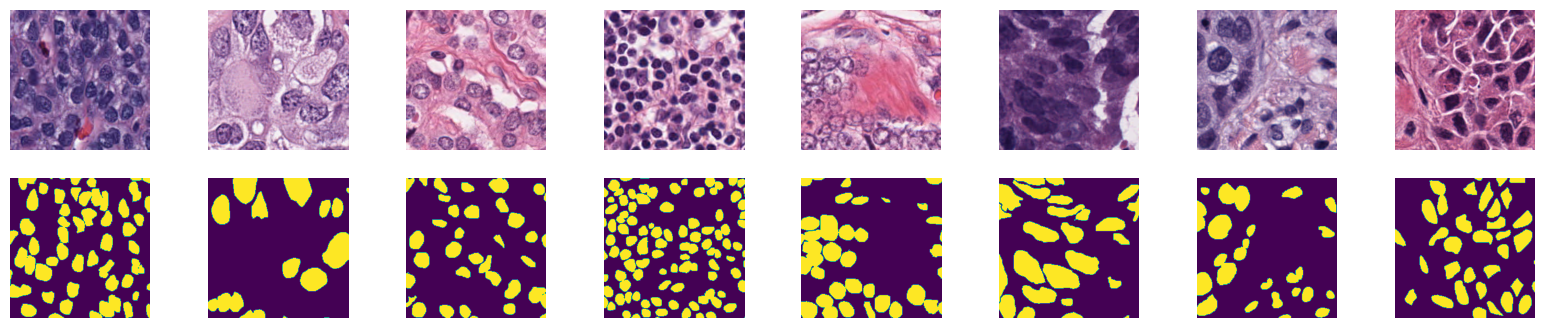

In [74]:
# @title Visualize Batch

images = next(iter(dataloader))

print(f"Number of train samples: {len(dataset)}")

fig, axes = plt.subplots(2, 8, figsize=(20, 4))
for i in range(8):
  axes[0,i].imshow(images["image"][i].permute(1, 2, 0))
  axes[0,i].axis('off')
  axes[1,i].imshow(images["mask"][i])
  axes[1,i].axis('off')

plt.show()

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [6]:
# @title Define the UNet

import torch
import torch.nn as nn

class ContractingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        pooled_x = self.pool(x)

        return pooled_x, x # need to return both pooled and pre-pooled for skip connections

class ExpansiveBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ExpansiveBlock, self).__init__()
        self.up_conv = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')

    def forward(self, pooled_x, pre_x):
        pooled_x = self.up_conv(pooled_x)

        diff_Y = pre_x.size()[2] - pooled_x.size()[2]
        diff_X = pre_x.size()[3] - pooled_x.size()[3]
        x_cropped = pre_x[:, :, diff_Y // 2 : pre_x.size()[2] - diff_Y // 2,
                                    diff_X // 2 : pre_x.size()[3] - diff_X // 2]

        x = torch.cat([pooled_x, x_cropped], dim=1) # add across the channel dimensions to double the channel count

        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)

        return x
        

class UNet(nn.Module):
    def __init__(self, num_classes = 2):
        super(UNet, self).__init__()

        # Contracting Path
        self.contract1 = ContractingBlock(3, 64)
        self.contract2 = ContractingBlock(64, 128)
        self.contract3 = ContractingBlock(128, 256)
        self.contract4 = ContractingBlock(256, 512)

        # Bottleneck Layer
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding='same'),
            nn.ReLU()             
        )
        
        # Expansive Path
        self.expand1 = ExpansiveBlock(1024, 512)
        self.expand2 = ExpansiveBlock(512, 256)
        self.expand3 = ExpansiveBlock(256, 128)
        self.expand4 = ExpansiveBlock(128, 64)

        # Final layer
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1, stride=1, padding='same')

    def forward(self, x):
        x, x_skip1 = self.contract1(x)
        x, x_skip2 = self.contract2(x)
        x, x_skip3 = self.contract3(x)
        x, x_skip4 = self.contract4(x)

        x = self.bottleneck(x)

        x = self.expand1(x, x_skip4)
        x = self.expand2(x, x_skip3)
        x = self.expand3(x, x_skip2)
        x = self.expand4(x, x_skip1)

        x = self.final_conv(x)
        
        return x


In [77]:
# @title Initialize Model (Untrained Model)

untrained_model = UNet()

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [42]:
# @title Run on Samples

output = untrained_model(images['image'])

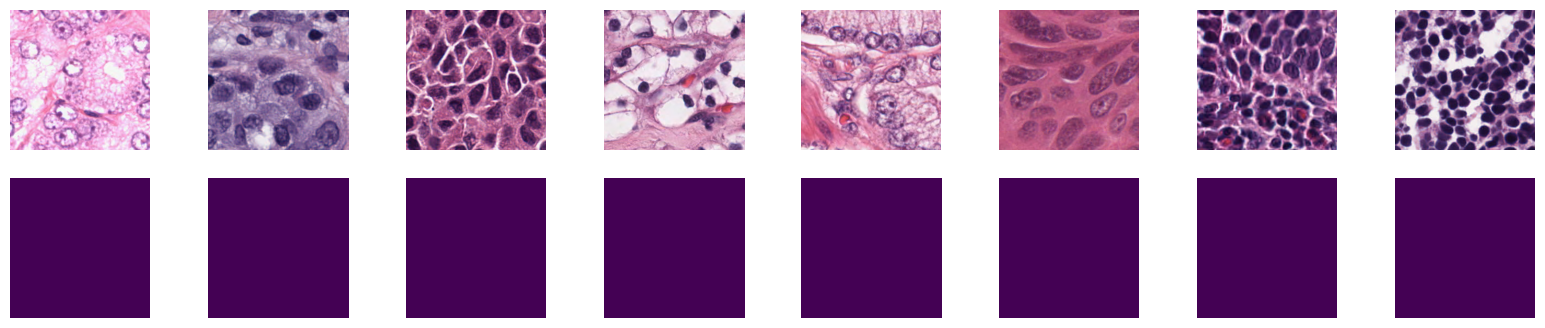

In [43]:
# @title Visualize First Batch Output (No training)
out_mask = (torch.softmax(output, dim = 1)[:,1,:,:].detach() > .5).float()

fig, axes = plt.subplots(2, 8, figsize=(20, 4))
for i in range(8):
  axes[0,i].imshow(images["image"][i].permute(1, 2, 0))
  axes[0,i].axis('off')
  axes[1,i].imshow(out_mask[i])
  axes[1,i].axis('off')

plt.show()

In [7]:
# @title Define Accuracy Function - Pixel Accuracy

def pixel_accuracy(pred, target):
    pred_classes = torch.argmax(pred, dim=1)  # pred = raw output from the model. convert [B, C=2, H, W] to [B, H, W] and collapsing dim=1, basically generating the mask.
    
    correct = (pred_classes == target).float()  # target = ground truth. correct = [B, H, W], 1.0 if correct else 0.0
    
    accuracy = correct.sum() / correct.numel()  # total correct / total pixels = pixel accuracry
    
    return accuracy.item() # extract the float without other info associated with the tensor

In [8]:
# @title Define Accuracy Function - Dice Score

def dice_score(pred, target, smooth=1e-6):
    num_classes = pred.shape[1] # 2nd dim of the predicted mask, which is num_classes
    
    # convert all numbers according to the probability of the num_classes (across the C dimension of [B, C, H, W]
    pred = torch.softmax(pred, dim=1)

    # one-hot encoding the target (ground truth) to match the output
    target_one_hot = F.one_hot(target, num_classes).permute(0, 3, 1, 2).float() 

    intersection = (pred * target_one_hot).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))

    dice = (2. * intersection + smooth) / (union + smooth)
    
    return dice.mean()

In [9]:
# @title Define Training Loop

def train(epochs, model, loss_fn, optimizer, train_loader, val_loader, lr_scheduler = None, name="iforgotoname"):
    best_dice_loss = float('inf')
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"): # add progress bar
            img = batch['image'].to(device=device, dtype=torch.float32)
            mask = batch['mask'].to(device=device, dtype=torch.int64)
    
            predicted_mask = model(img)
    
            loss = loss_fn(predicted_mask, mask)
    
            optimizer.zero_grad()
    
            loss.backward()
    
            optimizer.step()
    
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        # print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}")
    
        # Validation
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch in val_loader:
                img = batch['image'].to(device=device, dtype=torch.float32)
                mask = batch['mask'].to(device=device, dtype=torch.int64)
    
                predicted_mask = model(img)
                
                loss = 1 - dice_score(predicted_mask, mask) # we only care about dice loss for validation: for recognizing nuclei correctly
                
                val_loss += loss.item()
    
        avg_val_loss = val_loss / len(val_loader)

        if lr_scheduler: # will update the LR based on dice loss only during validation step
            lr_scheduler.step(avg_val_loss)
            
            for param_group in optimizer.param_groups:
                print(f"Current Learning Rate: {param_group['lr']:.6f}")
                
        # print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {avg_acc:.4f}")

        if avg_val_loss < best_dice_loss:
            best_dice_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            # print(f"New best model saved (Accuracy: {avg_acc:.4f})")

    if best_model_state is not None:
        torch.save(best_model_state, f"{name}_best_model.pt")
        # print(f"Best model saved with accuracy {best_val_acc:.4f}")

    return best_dice_loss

In [10]:
# @title Define Visualization 

def show_pic(model, images, name="iforgottoname"):
    model.load_state_dict(torch.load(f"{name}_best_model.pt"))
    model = model.to(device)
    model.eval()

    output_trained = model(images['image'].to(device=device))
    
    out_mask_trained = (torch.softmax(output_trained, dim = 1)[:,1,:,:].cpu() > .5).float()
    
    fig, axes = plt.subplots(3, 8, figsize=(20, 4))
    for i in range(8):
      axes[0,i].imshow(images["image"][i].permute(1, 2, 0))
      axes[0,i].axis('off')
      axes[1,i].imshow(out_mask_trained[i])
      axes[1,i].axis('off')
      axes[2,i].imshow(images["mask"][i])
      axes[2,i].axis('off')
    
    plt.show()

In [83]:
# @title Create a New Instance of Model to train - with CrossEntropy Loss

total_ce_loss = 0.0

for i in range(10):
    
    model = UNet()
    
    # do random split to set aside validation set
    train_dataset, val_dataset = random_split(dataset, [0.85, 0.15])
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)
    
    epochs = 20
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    model = model.to(device=device)
    
    total_ce_loss += train(epochs, model, F.cross_entropy, optimizer, train_loader, val_loader, name="cross_entropy")

print(f"Average model dice loss for trained with Cross Entropy Loss is {total_ce_loss/10:.4f}")


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Average model dice loss for trained with Cross Entropy Loss is 0.3184


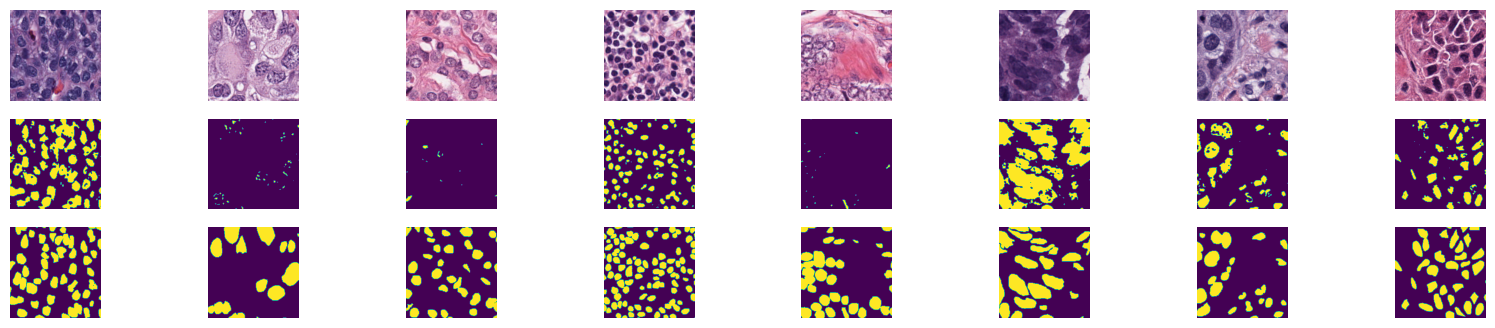

In [84]:
# @title Visualize After 20 Epoch

show_pic(model, images, name="cross_entropy")

In [11]:
# @title try the same thing but with Dice Loss instead of CrossEntropy Loss

def multiclass_dice_loss(pred, target, smooth=1e-5):
    num_classes = pred.shape[1] # 2nd dim of the predicted mask, which is num_classes
    
    # convert all numbers according to the probability of the num_classes (across the C dimension of [B, C, H, W]
    pred = torch.softmax(pred, dim=1)

    # one-hot encoding the target (ground truth) to match the output
    target_one_hot = F.one_hot(target, num_classes).permute(0, 3, 1, 2).float() 

    intersection = (pred * target_one_hot).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

In [86]:
# @title Model trained with Multiclass Dice Loss

total_multi_dice_loss = 0.0

for i in range(10):
    
    model = UNet()

    # do random split to set aside validation set
    train_dataset, val_dataset = random_split(dataset, [0.85, 0.15])
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)
    
    epochs = 20
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    model = model.to(device=device)
    
    total_multi_dice_loss += train(epochs, model, multiclass_dice_loss, optimizer, train_loader, val_loader, name="multiclass_dice")

print(f"Average model dice loss for trained with Multiclass Dice Loss is {total_multi_dice_loss/10:.4f}")
      

Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Average model dice loss for trained with Multiclass Dice Loss is 0.2255


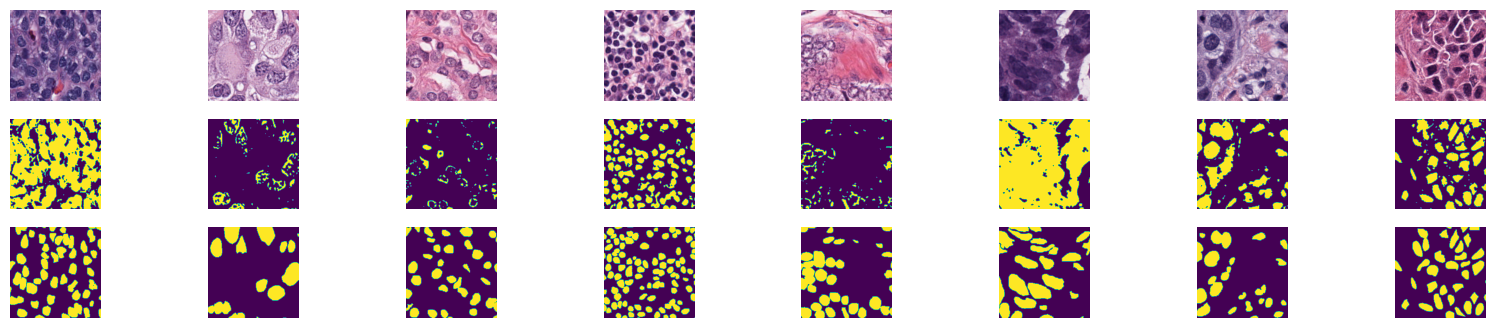

In [87]:
# Visualize after 20 Epochs: Trained using Dice Loss

show_pic(model, images, name="multiclass_dice")

In [88]:
# @title Hybrid Loss Function: Dice Loss + CrossEntropy

def hybrid_loss(pred, target, dice_weight=0.5):

    # CrossEntropy Loss
    ce = F.cross_entropy(pred, target)

    # Multiclass Dice Loss
    dice_loss = multiclass_dice_loss(pred, target)

    return (1 - dice_weight) * ce + dice_weight * dice_loss

In [89]:
# @title Use Hybrid Loss Function

total_hybrid_loss = 0.0

for i in range(10):
    model = UNet()

    # do random split to set aside validation set
    train_dataset, val_dataset = random_split(dataset, [0.85, 0.15])
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)
    
    epochs = 20
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    model = model.to(device=device)
    
    total_hybrid_loss += train(epochs, model, hybrid_loss, optimizer, train_loader, val_loader, name="hybrid_loss")

print(f"Average model dice loss for trained with Hybrid Loss is {total_hybrid_loss/10:.4f}")
      

Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Average model dice loss for trained with Hybrid Loss is 0.2956


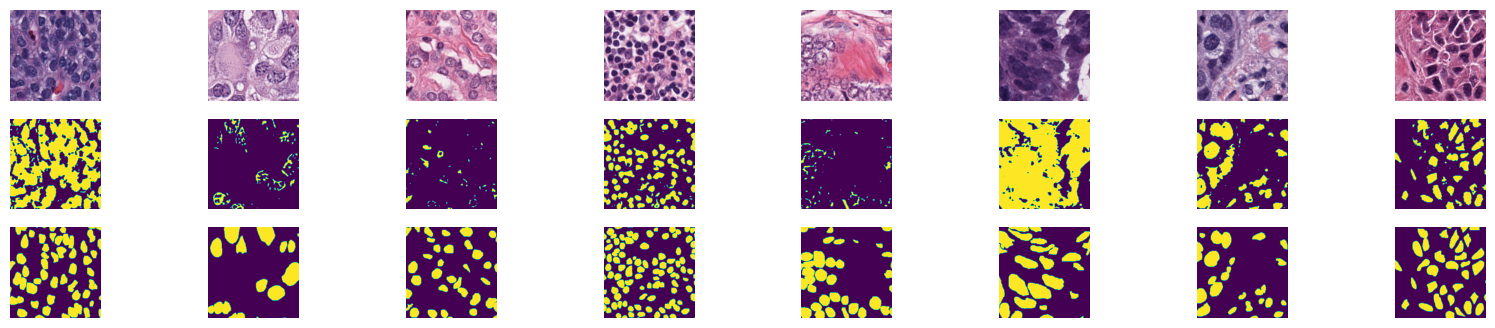

In [91]:
# Visualize after 20 Epochs: Trained using Hybrid Loss

show_pic(model, images, name="hybrid_loss")

In [92]:
# @title Model Trained with Multiclass Dice Loss + Additional Data Augmentation to Improve Overfitting Problem

total_data_aug_loss = 0.0

for i in range(10):

    # create a new dataset

    transform = v2.Compose([v2.RandomCrop((256,256)), v2.RandomHorizontalFlip(), v2.RandomVerticalFlip(), v2.RandomRotation(180)])
    
    aug_dataset = MoNuSegDataset('MoNuSeg/MoNuSeg 2018 Training Data', transform = transform)
    
    
    model = UNet()
    
    # do random split to set aside validation set
    train_dataset, val_dataset = random_split(aug_dataset, [0.85, 0.15])
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)
    
    epochs = 20
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    model = model.to(device=device)
    
    total_data_aug_loss += train(epochs, model, multiclass_dice_loss, optimizer, train_loader, val_loader, name="multiclass_dice_data_aug")

print(f"Average model dice loss for trained with Multiclass Dice Loss + Data Aug is {total_data_aug_loss/10:.4f}")


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Average model dice loss for trained with Multiclass Dice Loss + Data Aug is 0.2768


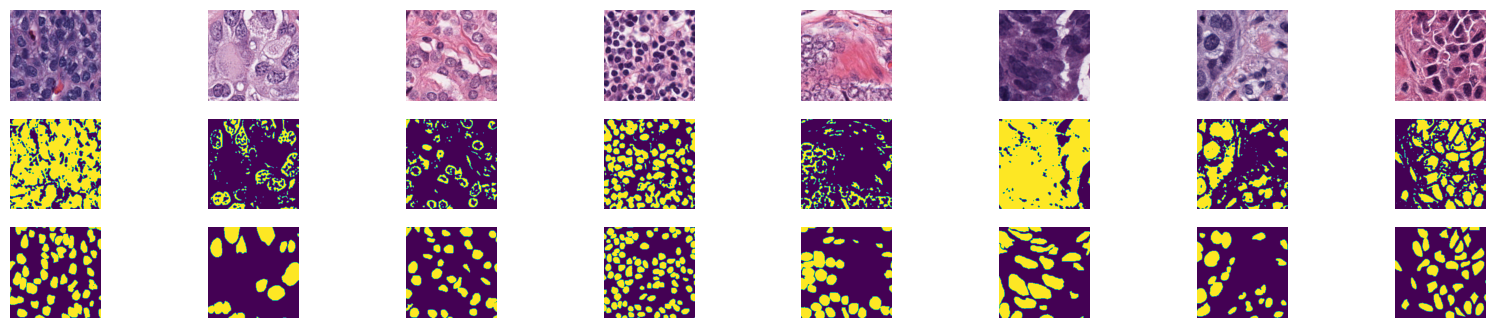

In [93]:
# @title Visualize after Data Augmentation

show_pic(model, images, name="multiclass_dice_data_aug")

In [94]:
# @title Model Trained with Multiclass Dice Loss + LR Scheduling

total_schedule_loss = 0.0

for i in range(10):
    
    model = UNet()

    # do random split to set aside validation set
    train_dataset, val_dataset = random_split(dataset, [0.85, 0.15])
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)
    
    epochs = 20
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    model = model.to(device=device)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    total_schedule_loss += train(epochs, model, multiclass_dice_loss, optimizer, train_loader, val_loader, lr_scheduler = scheduler, name="multiclass_dice_lr_scheduling")

print(f"Average model dice loss for trained with Multiclass Dice Loss + Lr Scheduling is {total_schedule_loss/10:.4f}")


Epoch 1/20: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  3.02it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.000500


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.000500


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.000500


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


Current Learning Rate: 0.000250


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


Current Learning Rate: 0.000500


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.000500


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.000500


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.000500


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.000500


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.000250


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.000250


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.000250


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  3.02it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  3.02it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.000500


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.000500
Average model dice loss for trained with Multiclass Dice Loss + Lr Scheduling is 0.2378


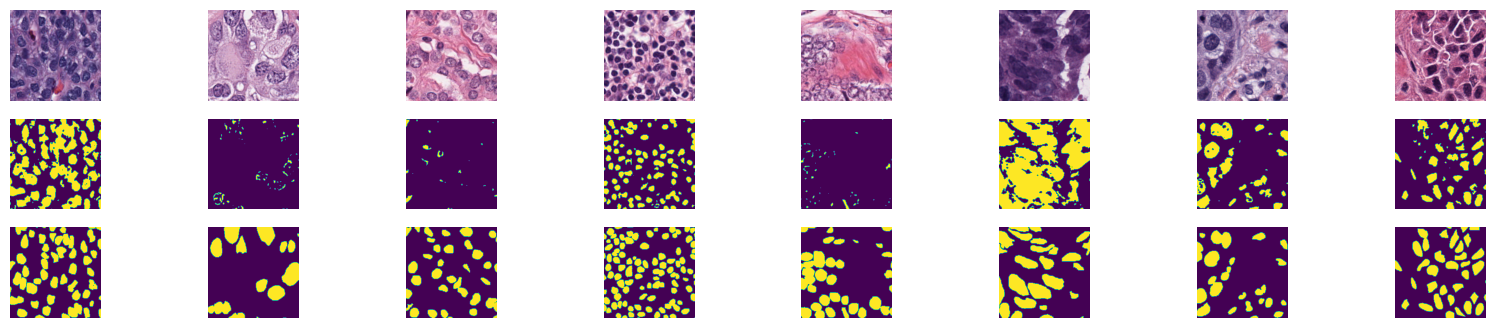

In [96]:
show_pic(model, images, name="multiclass_dice_lr_scheduling")

In [97]:
# @title Apply Regularization - Weight Decay (L2 Regularization to encourage smaller weight)

total_decay_loss = 0.0

for i in range(10):
    
    model = UNet()

    # do random split to set aside validation set
    train_dataset, val_dataset = random_split(dataset, [0.85, 0.15])
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)
    
    epochs = 20
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    
    model = model.to(device=device)
    
    total_decay_loss += train(epochs, model, multiclass_dice_loss, optimizer, train_loader, val_loader, name="multiclass_dice_weight_decay")

print(f"Average model dice loss for trained with Multiclass Dice Loss + Weight Decay is {total_decay_loss/10:.4f}")


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Average model dice loss for trained with Multiclass Dice Loss + Weight Decay is 0.2413


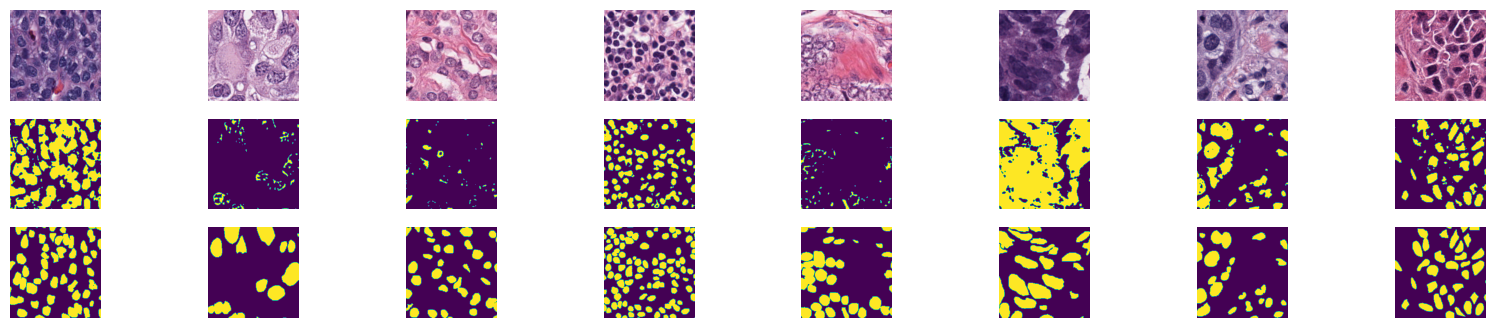

In [98]:
# @title Visualize after Regularization

show_pic(model, images, name="multiclass_dice_weight_decay")

In [99]:
# @title Increase Batchsize

total_batchsize_loss = 0.0

for i in range(10):
    
    model = UNet()

    # do random split to set aside validation set
    train_dataset, val_dataset = random_split(dataset, [0.85, 0.15])
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)
    
    epochs = 20
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    model = model.to(device=device)
    
    total_batchsize_loss += train(epochs, model, multiclass_dice_loss, optimizer, train_loader, val_loader, name="multiclass_dice_batchsize")

print(f"Average model dice loss for trained with Multiclass Dice Loss + Batchsize Increase is {total_batchsize_loss/10:.4f}")


Epoch 20/20: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Average model dice loss for trained with Multiclass Dice Loss + Batchsize Increase is 0.2406


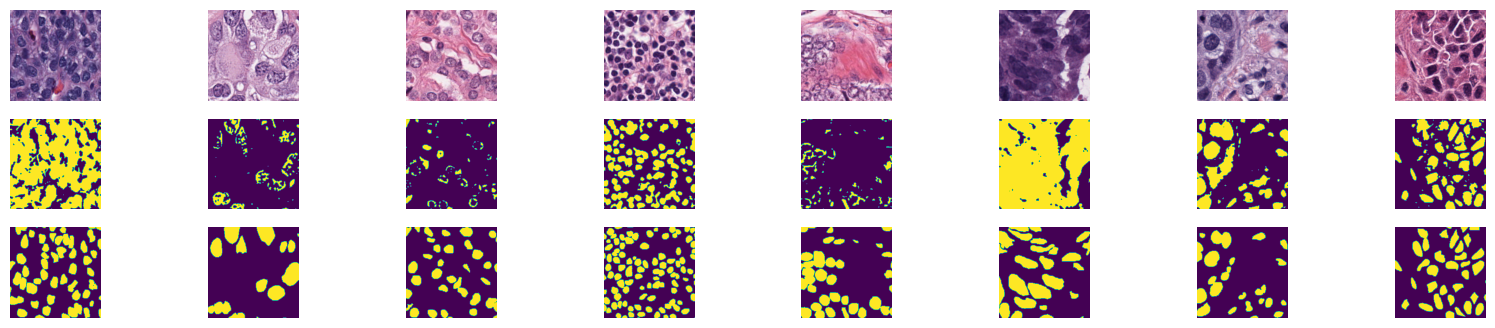

In [100]:
show_pic(model, images, name="multiclass_dice_batchsize")

In [101]:
# @title Add Data Augmentation: Brightness/Contrast

total_bright_contrast_loss = 0.0

for i in range(10):
    aug_dataset = MoNuSegDataset('MoNuSeg/MoNuSeg 2018 Training Data', bright_contrast=True)
    train_dataset, val_dataset = random_split(aug_dataset, [0.85, 0.15])

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)

    model = UNet()
    
    epochs = 20
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    model = model.to(device=device)
    
    total_bright_contrast_loss += train(epochs, model, multiclass_dice_loss, optimizer, train_loader, val_loader, name="multiclass_dice_bright_contrast")

print(f"Average model dice loss for trained with Multiclass Dice Loss + Bright/Contrast Data Aug is {total_bright_contrast_loss/10:.4f}")


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


Average model dice loss for trained with Multiclass Dice Loss + Bright/Contrast Data Aug is 0.2422


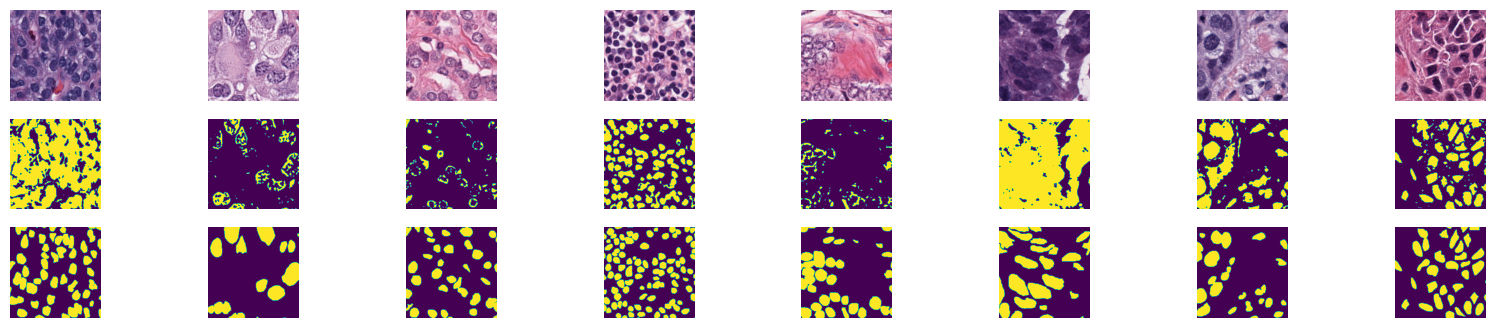

In [102]:
show_pic(model, images, name="multiclass_dice_bright_contrast")

In [111]:
# @title Try to find the best method: Baseline = Multiclass Dice Loss Only

total_multi_dice_loss_2 = 0.0

for i in range(10):
    
    model = UNet()

    # do random split to set aside validation set
    train_dataset, val_dataset = random_split(dataset, [0.85, 0.15])
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)
    
    epochs = 20
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    model = model.to(device=device)
    
    total_multi_dice_loss_2 += train(epochs, model, multiclass_dice_loss, optimizer, train_loader, val_loader, name="multiclass_dice_2")

print(f"Average model dice loss for trained with Multiclass Dice Loss is {total_multi_dice_loss_2/10:.4f}")

Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Average model dice loss for trained with Multiclass Dice Loss is 0.2690


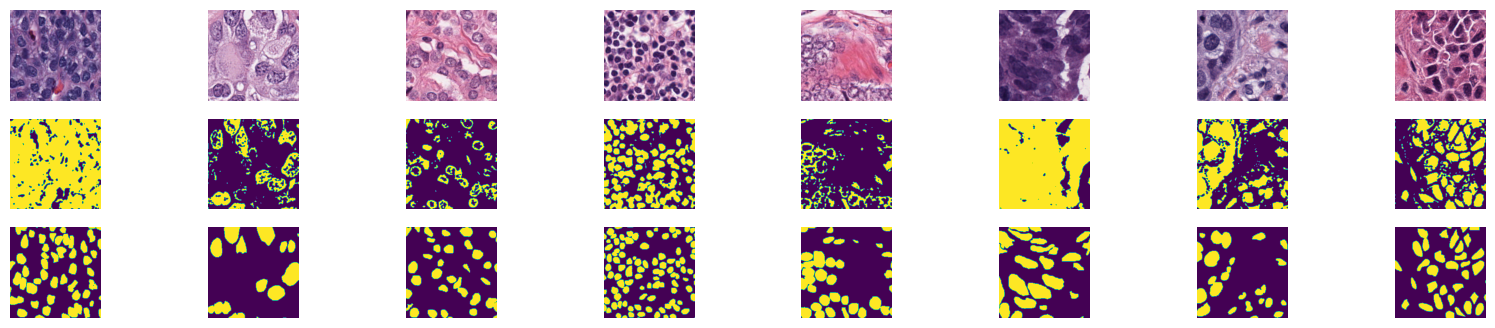

In [112]:
show_pic(model, images, name="multiclass_dice_2")

In [106]:
# @title Try to find the best method: Baseline + LR Scheduling

total_schedule_loss_2 = 0.0

for i in range(10):
    
    model = UNet()

    # do random split to set aside validation set
    train_dataset, val_dataset = random_split(dataset, [0.85, 0.15])
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)
    
    epochs = 20
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    model = model.to(device=device)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    total_schedule_loss_2 += train(epochs, model, multiclass_dice_loss, optimizer, train_loader, val_loader, lr_scheduler = scheduler, name="multiclass_dice_lr_scheduling_2")

print(f"Average model dice loss for trained with Multiclass Dice Loss + Lr Scheduling is {total_schedule_loss_2/10:.4f}")

Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.000500


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.000500


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Current Learning Rate: 0.000500


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.000500


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.000500


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.000500


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.000250


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.000250


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


Current Learning Rate: 0.000250


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.000500


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.000500


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.000500


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.000500


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.000500


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.000500


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.000500


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.000500


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]


Current Learning Rate: 0.000500


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.000250
Average model dice loss for trained with Multiclass Dice Loss + Lr Scheduling is 0.2397


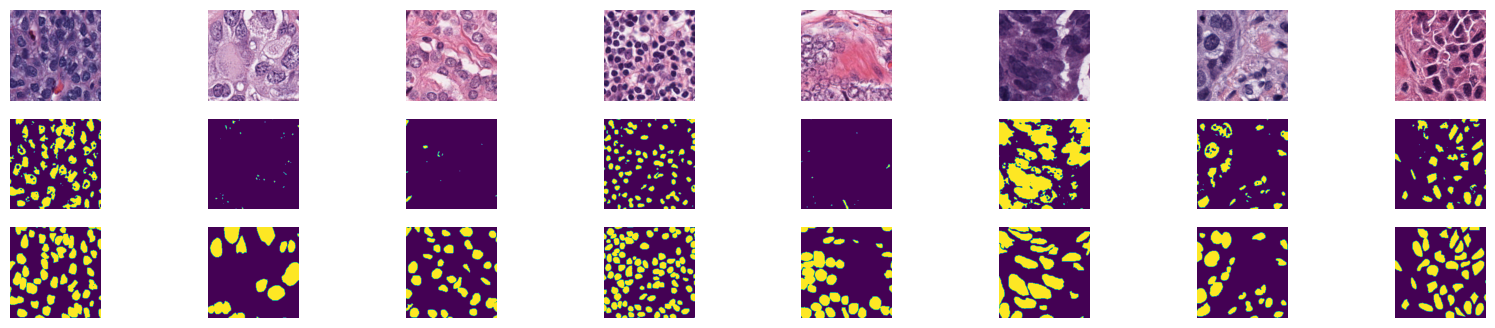

In [107]:
show_pic(model, images, name="multiclass_dice_lr_scheduling_2")

In [109]:
# @title Try to find the best method: Baseline + LR Scheduling + Weight Decay

total_decay_loss_2 = 0.0

for i in range(10):
    
    model = UNet()

    # do random split to set aside validation set
    train_dataset, val_dataset = random_split(dataset, [0.85, 0.15])
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)
    
    epochs = 20
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    
    model = model.to(device=device)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    total_decay_loss_2 += train(epochs, model, multiclass_dice_loss, optimizer, train_loader, val_loader, lr_scheduler = scheduler, name="multiclass_dice_lr_scheduling__weight_decay")

print(f"Average model dice loss for trained with Multiclass Dice Loss + Lr Scheduling + Weight Decay is {total_decay_loss_2/10:.4f}")

Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.000500


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.000500


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.000500


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.000500


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.000500


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.000500


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.000500


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.000500


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.000500
Average model dice loss for trained with Multiclass Dice Loss + Lr Scheduling + Weight Decay is 0.2138


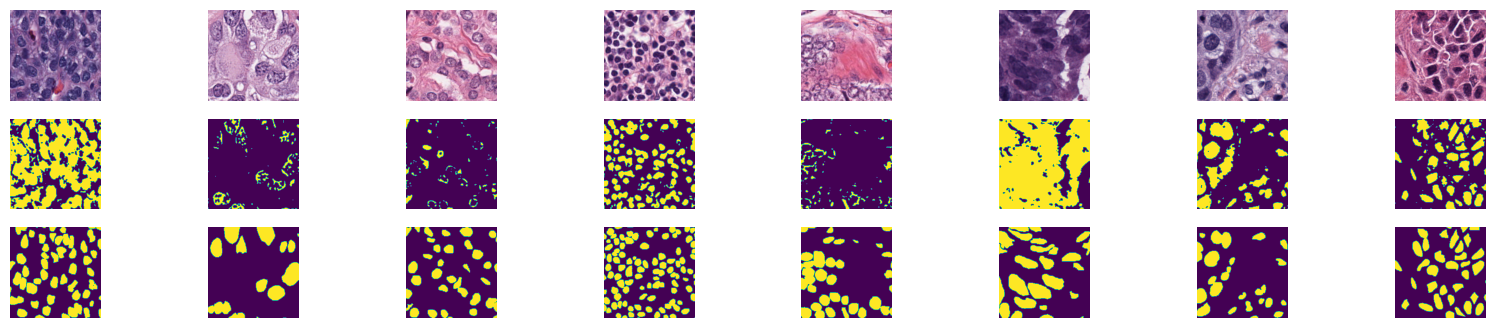

In [113]:
show_pic(model, images, name="multiclass_dice_lr_scheduling__weight_decay")

In [116]:
# @title Try to find the best method: Baseline + LR Scheduling + Weight Decay + Larger Batch Size

total_batchsize_loss_2 = 0.0

for i in range(10):
    
    model = UNet()

    # do random split to set aside validation set
    train_dataset, val_dataset = random_split(dataset, [0.85, 0.15])
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)
    
    epochs = 20
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    
    model = model.to(device=device)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    total_batchsize_loss_2 += train(epochs, model, multiclass_dice_loss, optimizer, train_loader, val_loader, lr_scheduler = scheduler, name="multiclass_dice_lr_scheduling__weight_decay_batchsize")

print(f"Average model dice loss for trained with Multiclass Dice Loss + Lr Scheduling + Weight Decay + larger batchsize is {total_batchsize_loss_2/10:.4f}")

Epoch 1/20: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 1/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Current Learning Rate: 0.001000


Epoch 1/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 1/20: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Current Learning Rate: 0.001000


Epoch 1/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 1/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 1/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Current Learning Rate: 0.000500
Average model dice loss for trained with Multiclass Dice Loss + Lr Scheduling + Weight Decay + larger batchsize is 0.2438


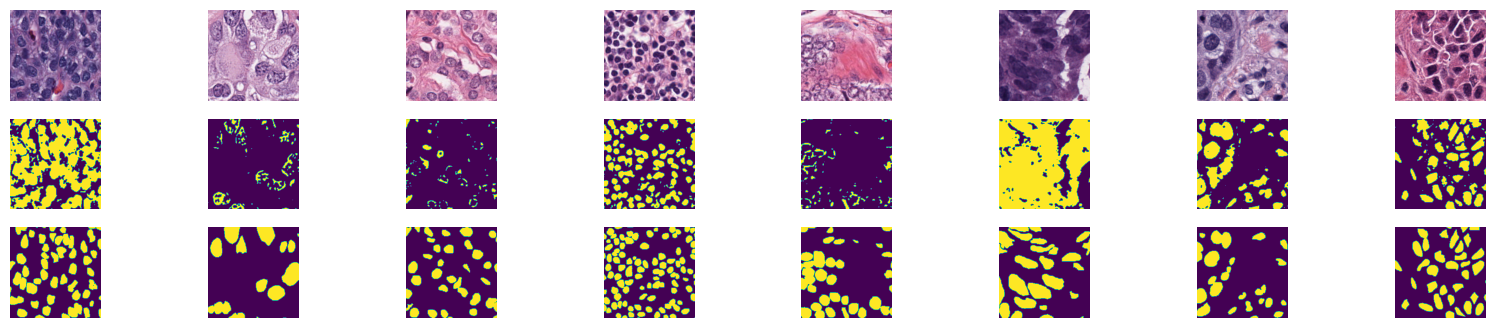

In [117]:
show_pic(model, images, name="multiclass_dice_lr_scheduling__weight_decay_batchsize")

In [121]:
# @title Try to find the best method: Baseline + LR Scheduling + Weight Decay + Larger Batch Size + brightness/contrast data aug

total_bc_loss_2 = 0.0

for i in range(10):
    
    model = UNet()

    aug_dataset = MoNuSegDataset('MoNuSeg/MoNuSeg 2018 Training Data', bright_contrast=True)
    train_dataset, val_dataset = random_split(aug_dataset, [0.85, 0.15])
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)
    
    epochs = 20
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    
    model = model.to(device=device)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    total_bc_loss_2 += train(epochs, model, multiclass_dice_loss, optimizer, train_loader, val_loader, lr_scheduler = scheduler, name="multiclass_dice_lr_scheduling__weight_decay_batchsize_bc")

print(f"Average model dice loss for trained with Multiclass Dice Loss + Lr Scheduling + Weight Decay + larger batchsize + brightness/contrast is {total_bc_loss_2/10:.4f}")

Epoch 1/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 1/20: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Current Learning Rate: 0.001000


Epoch 1/20: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Current Learning Rate: 0.001000


Epoch 1/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:04<00:00,  2.39s/it]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 1/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Current Learning Rate: 0.000500
Average model dice loss for trained with Multiclass Dice Loss + Lr Scheduling + Weight Decay + larger batchsize + brightness/contrast is 0.2546


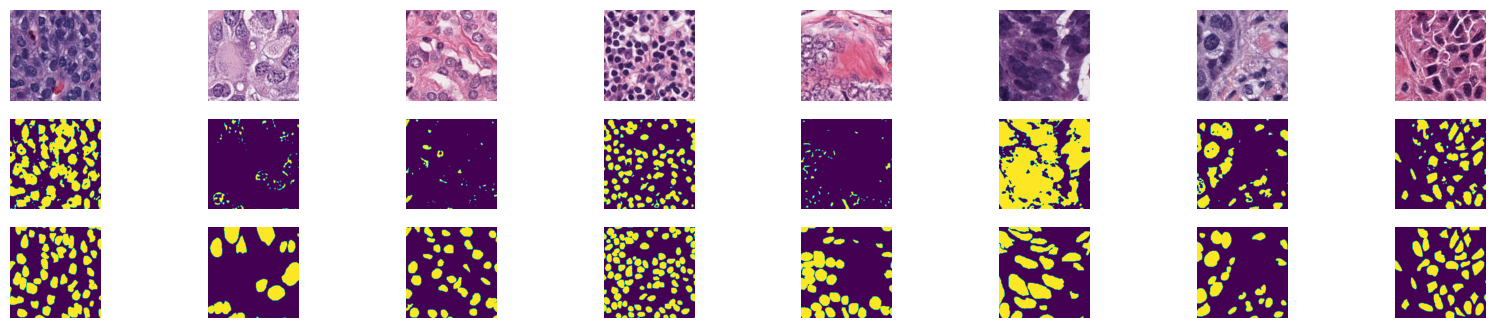

In [122]:
show_pic(model, images, name="multiclass_dice_lr_scheduling__weight_decay_batchsize_bc")

In [12]:
# @title Model trained with Multiclass Dice Loss, Add Standard Deviation

dice_losses = []

for i in range(10):
    model = UNet()

    train_dataset, val_dataset = random_split(dataset, [0.85, 0.15])

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)

    epochs = 20
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model = model.to(device=device)

    best_loss = train(epochs, model, multiclass_dice_loss, optimizer, train_loader, val_loader, name="dice_sched_decay")
    dice_losses.append(best_loss)

dice_losses = np.array(dice_losses)
print(f"Average model dice loss for trained with Multiclass Dice only is {dice_losses.mean():.4f}")
print(f"With Standard Deviation = {dice_losses.std():.4f}")

Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Average model dice loss for trained with Multiclass Dice only is 0.2421
With Standard Deviation = 0.0812


In [13]:
# @title Evaluate: Multiclass Dice Loss + LR Scheduling + Weight Decay

dice_losses = []

for i in range(10):
    model = UNet()

    train_dataset, val_dataset = random_split(dataset, [0.85, 0.15])

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)

    epochs = 20
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    model = model.to(device=device)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    best_loss = train(epochs, model, multiclass_dice_loss, optimizer, train_loader, val_loader, lr_scheduler=scheduler, name="dice_sched_decay")
    dice_losses.append(best_loss)

dice_losses = np.array(dice_losses)
print(f"Average model dice loss for trained with Multiclass Dice + Lr Scheduler + Weight Decay is {dice_losses.mean():.4f}")
print(f"With Standard Deviation = {dice_losses.std():.4f}")

Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Current Learning Rate: 0.000500


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Current Learning Rate: 0.000500


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Current Learning Rate: 0.001000


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.000500


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.000500


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Current Learning Rate: 0.000500


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Current Learning Rate: 0.000250


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Current Learning Rate: 0.000500


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


Current Learning Rate: 0.000500


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Current Learning Rate: 0.000500


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Current Learning Rate: 0.000500


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.000500


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.000500


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.000500


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Current Learning Rate: 0.000500


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.000500


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.000250


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.000250


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Current Learning Rate: 0.000250


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.000250


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.000500


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.000500


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Current Learning Rate: 0.000500


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Current Learning Rate: 0.000500


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.000500


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.000500


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.000250


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.000250


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.000250


Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


Current Learning Rate: 0.000500
Average model dice loss for trained with Multiclass Dice + Lr Scheduler + Weight Decay is 0.2642
With Standard Deviation = 0.0545


In [14]:
# @title Evaluate: Multiclass Dice Loss + LR Scheduling + Weight Decay + Larger Batch Size + Brightness/Contrast Data Aug

dice_losses = []

for i in range(10):
    model = UNet()

    aug_dataset = MoNuSegDataset('MoNuSeg/MoNuSeg 2018 Training Data', bright_contrast=True)
    train_dataset, val_dataset = random_split(aug_dataset, [0.85, 0.15])
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)

    epochs = 20
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    model = model.to(device=device)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    best_loss = train(epochs, model, multiclass_dice_loss, optimizer, train_loader, val_loader, lr_scheduler=scheduler, name="dice_sched_decay_bs_bc")
    dice_losses.append(best_loss)

dice_losses = np.array(dice_losses)
print(f"Average model dice loss for trained with Multiclass Dice + Lr Scheduler + Weight Decay + larger Batch Size + Brightness/Contrass Data Aug is {dice_losses.mean():.4f}")
print(f"With Standard Deviation = {dice_losses.std():.4f}")

Epoch 1/20: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 1/20: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Current Learning Rate: 0.000500


Epoch 19/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Current Learning Rate: 0.001000


Epoch 1/20: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:03<00:00,  1.78s/it]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.000500


Epoch 20/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 1/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.000500


Epoch 1/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 1/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 1/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Current Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Current Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 6/20: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Current Learning Rate: 0.001000


Epoch 7/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 8/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 9/20: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Current Learning Rate: 0.001000


Epoch 10/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 11/20: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Current Learning Rate: 0.001000


Epoch 12/20: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Current Learning Rate: 0.001000


Epoch 13/20: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Current Learning Rate: 0.001000


Epoch 14/20: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Current Learning Rate: 0.001000


Epoch 15/20: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Current Learning Rate: 0.001000


Epoch 16/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000


Epoch 17/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 18/20: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Current Learning Rate: 0.001000


Epoch 19/20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Current Learning Rate: 0.001000


Epoch 20/20: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Current Learning Rate: 0.001000
Average model dice loss for trained with Multiclass Dice + Lr Scheduler + Weight Decay + larger Batch Size + Brightness/Contrass Data Aug is 0.2517
With Standard Deviation = 0.0441
